# Deep Mixture Cure Model
# Contents
<a href='#LoadingLibraries'>1. Load all neccessary libraries</a><br/>
<a href='#EDA'>2. Explanatory Data Analysis</a><br/>
<a href='#ChooseFeatures'>3. Choose Features from Earlier Section or External Files</a><br/>
<a href='#ImputeWinsorizeStandardize'>4. Imputation, Winsorization, Standardization</a><br/>
<a href='#TrainTestModels'>5. Train & Test the Models</a><br/>
<a href='#FeatureAnalysis'>6. Analyze Model Features Importance and their Correlation</a><br/>
<a href='#ScoreMapping'>7. Build Score Mapping Functions</a><br/>
<a href='#CreateModelPickle'>8. Create Deployable Pickle File</a><br/>
<a href='#ModelComparison'>9. Compare Model Scores against each other</a><br/>
<a href='#AnalyzeFilter'>10. Analyze the impact of various filters on training data</a><br/>
<a href='#FeatureSelectionGAXGBoost'>11. Feature Selection via Genetic Algorithm - xgboost</a><br/>
<a href='#FeatureSelectionGAXLogReg'>12. Feature Selection via Genetic Algorithm - logreg </a><br/>

# Load all neccessary libraries and data<a id='LoadingLibraries'></a>

In [9]:
import pandas as pd
import numpy as np
import lifelines
from lifelines.utils import to_long_format

# Explanatory Analysis of Data<a id='EDA'></a>

In [10]:
loan_m = pd.read_csv('../mortgage/mortgage.csv')
loan_m['loan_time'] = loan_m.time - loan_m.orig_time

100


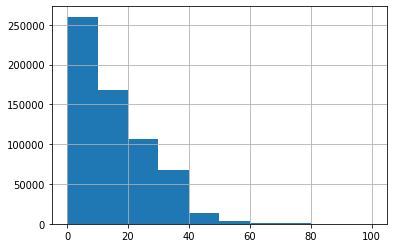

In [11]:
loan_m['loan_time'].hist()
print(loan_m['loan_time'].max())
#the max Y_x we could have, we have data until month 100, but Y_max 72, predit the survival in next 6 years at monthly rate.

60


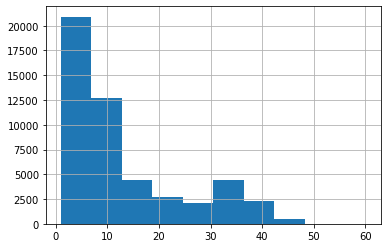

In [12]:
loan_m.groupby('id').count().time.hist()
print(loan_m.groupby('id').count().time.max())   #max observation period

In [150]:
cox_var = [var for var in loan_m.columns if not var in ['time', 'orig_time', 'first_time', 'mat_time',
'payoff_time', 'status_time', 'loan_time','label', 'default_time']]
print(cox_var)
orig_var = [ 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']
varying_co = ['balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time']

['id', 'balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']


In [183]:
loan_m[['id', 'time', 'uer_time'] ].sort_values('time')
# + varying_co].

,id,time,uer_time
218722,18056,1,3.8
218878,18069,1,3.8
81547,7779,1,3.8
81542,7778,1,3.8
218872,18068,1,3.8
...,...,...,...
598786,47430,60,5.7
263370,21080,60,5.7
380264,30741,60,5.7
598725,47421,60,5.7


In [175]:
oan_m[['id'] + orig_var].nunique()

id                         50000
REtype_CO_orig_time            2
REtype_PU_orig_time            2
REtype_SF_orig_time            2
investor_orig_time             2
balance_orig_time          10694
FICO_orig_time               397
LTV_orig_time                552
Interest_Rate_orig_time     1825
hpi_orig_time                 97
dtype: int64

In [163]:
# prepare data for cox_regression without varying data
data_cox = loan_m[orig_var + ['id']]
data_cox = data_cox.groupby('id').median()
duration = loan_m.groupby('id').agg({'time':'count', 'status_time': 'max'}).reset_index()
duration.columns = ['id', 'duration', 'label']
data_cox = pd.merge(data_cox, duration, on = 'id', how = 'left')
data_cox['label'] = [l if l == 1 else 0 for l in data_cox['label'] ]

<AxesSubplot:xlabel='timeline'>

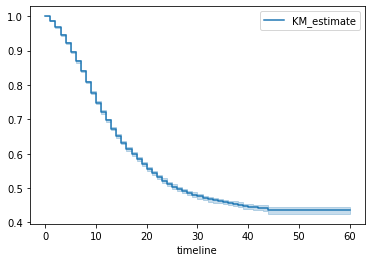

In [167]:
# kaplan cureve
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

T = data_cox["duration"]
E = data_cox["label"]

kmf.fit(T, event_observed=E)
kmf.plot()

In [90]:
(loan_m.groupby('id').agg('nunique') -1).sum(axis = 0)
# id:                    'id'
# status:                'default_time'  0 or 1
# obs_time:              'time', loan_m.groupby('id').interest_rate_time.count().values
# covatiates:             'hpi_orig_time', 
# time_varying covariate: hpi_time 'house_price_idx', 'interest_rate_time', 'gdp_time', uer_time 'unemployment_rate',
                          

id                              0
time                       572150
orig_time                      49
first_time                      0
mat_time                      860
balance_time               445253
LTV_time                   571925
interest_rate_time          53975
hpi_time                   572150
gdp_time                   572150
uer_time                   398150
REtype_CO_orig_time             5
REtype_PU_orig_time             3
REtype_SF_orig_time            55
investor_orig_time             14
balance_orig_time              15
FICO_orig_time                383
LTV_orig_time                  35
Interest_Rate_orig_time      4312
hpi_orig_time                  49
default_time                14531
payoff_time                 23527
status_time                 38058
loan_time                  572138
label                       38058
dtype: int64

In [184]:
from data_preprocess import *

In [185]:
feature_list = varying_co

In [186]:
data_process = preprocess_data(data_original =loan_m, feature_list = feature_list,)

In [187]:
Dimension, DATA, MASK, data_mi, pat_info = data_process.preprocess()

[[48.]
 [26.]
 [29.]
 ...
 [60.]
 [60.]
 [60.]]


In [262]:
pat_info[:,4]

array([24.,  2.,  5., ...,  9.,  9.,  9.])

In [270]:
mask = np.zeros(DATA[0].shape[:2]) 
for i in range(len(pat_info[:,4])):
    mask[i, :int(pat_info[i,4])] = 1

# RNN 

In [66]:
# first neural network with keras tutorial
import tensorflow as tf
from tensorflow import keras as keras
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from datetime import datetime


In [71]:
DATA[2].shape

(50000, 1)

In [374]:
inputs = DATA[0][:50, :,:]
print(inputs.shape)

tf.random.set_seed(123)

masking = tf.keras.layers.Masking(mask_value=0., input_shape=inputs.shape[1:])(inputs)
h = tf.keras.layers.LSTM(48, return_sequences=True)(masking)
output = tf.keras.layers.LSTM(1, return_sequences=True)(h)
output_soft = tf.keras.layers.Softmax(axis=0)(output)
print(output_soft.shape)

(50, 60, 7)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(50, 60, 1)


In [339]:
#compute loss
#log_likelihood
print(mask[:50,].shape)
print(output.shape)
mask_ = tf.constant(mask[:50,], shape = (50, 60, 1), dtype = 'float32')

(50, 60)
(50, 60, 1)


In [384]:
S_t = tf.reduce_sum(tf.math.multiply(output_soft, mask_[:50,]), axis = 1)

In [ ]:
### CONSTRUCT MULTICELL FOR MULTI-LAYER RNNS
def create_rnn_cell(num_units, n_cell, drop_prob, RNN_type, activation_fn,
                    return_sequences=True, return_state=True): 
    '''
        GOAL         : create multi-cell (including a single cell) to construct multi-layer RNN
        num_units    : number of units in each layer, dimension of output space
        num_layers   : number of layers in MulticellRNN
        drop_prob    : keep probabilty [0, 1) 1 if no dropout
        RNN_type     : either 'LSTM' or 'GRU'
    '''
    if activation_fn == 'None':
        activation_fn = tf.nn.tanh

    cells = []
    for _ in range(n_cell):
        if RNN_type == 'GRU':
            cell = tf.keras.layers.GRUCell(num_units, activation=activation_fn, recurrent_dropout=drop_prob)
        elif RNN_type == 'LSTM':
            cell = tf.keras.layers.LSTMCell(num_units, activation=activation_fn, recurrent_dropout=drop_prob)
            cells.append(cell)
    lstm_layer = tf.keras.layers.RNN(cells, 
                                     return_sequences, 
                                     return_state) 
    return lstm_layer

In [12]:
inputs = tf.random.normal([500, 24, 10])
outputs = tf.random.normal([500, ])
# [batch, timesteps, feature] # timesteps refers to Y_max, feature = n_featuresto use
'''
e.g.
data_x = numpy.array([
    # Datapoint 1
    [
        # Input features at timestep 1
        [1, 2, 3],
        # Input features at timestep 2
        [4, 5, 6]
    ],
    # Datapoint 2
    [
        # Features at timestep 1
        [7, 8, 9],
        # Features at timestep 2
        [10, 11, 12]
    ]
])
(batch, 2, 3)
'''

from tensorflow.python.framework import ops
ops.reset_default_graph()

Input_1= Input(shape=(24, 10, ), )
Rnn = create_rnn_cell(1, 24, drop_prob = 0.3, RNN_type = 'LSTM',  #n_units, n_cells
                      activation_fn = None, 
                      return_sequences=True, 
                      return_state=True)
state = Rnn(Input_1)
out_pi = Dense(1, activation=tf.nn.sigmoid, name="decoder")(state[1][0])


#output = state[0] # batches*timestamps*number_inputs

#

In [13]:
model_1 = Model(inputs=Input_1, outputs=out_pi,)
model_1.compile(
    optimizer='sgd',
    loss='mse',
    metrics=['mse'])

model_1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24, 10)]          0         
_________________________________________________________________
rnn (RNN)                    [(None, 24, 1), [(None, 1 324       
_________________________________________________________________
decoder (Dense)              (None, 1)                 2         
Total params: 326
Trainable params: 326
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model.
model_1.fit(
    inputs,
    outputs, 
    batch_size=30,
    epochs=30, 
    callbacks=[tensorboard_callback], 
    steps_per_epoch = 20)

Epoch 1/30
20/20 [==============================] - 24s 1s/step - loss: 1.1564 - mse: 1.1564
Epoch 2/30
20/20 [==============================] - 5s 234ms/step - loss: 1.1677 - mse: 1.1677
Epoch 3/30
20/20 [==============================] - 5s 235ms/step - loss: 1.1509 - mse: 1.1509
Epoch 4/30
20/20 [==============================] - 5s 232ms/step - loss: 1.0241 - mse: 1.0241
Epoch 5/30
20/20 [==============================] - 5s 232ms/step - loss: 1.1341 - mse: 1.1341
Epoch 6/30
20/20 [==============================] - 5s 231ms/step - loss: 1.0381 - mse: 1.0381
Epoch 7/30
20/20 [==============================] - 5s 237ms/step - loss: 1.0469 - mse: 1.0469
Epoch 8/30
20/20 [==============================] - 5s 236ms/step - loss: 1.0673 - mse: 1.0673
Epoch 9/30
20/20 [==============================] - 5s 258ms/step - loss: 0.9842 - mse: 0.9842
Epoch 10/30
20/20 [==============================] - 5s 269ms/step - loss: 1.1233 - mse: 1.1233
Epoch 11/30
20/20 [==============================] 

In [376]:
model_1.summary()

Model: "functional_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 24, 10)]          0         
_________________________________________________________________
rnn_37 (RNN)                 [(None, 24, 1), [(None, 1 48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


In [39]:
encoder_input = tf.keras.layers.Input(shape=(None,))

# NN

In [1]:
import tensorboard
tensorboard.__version__

'2.3.0'

In [5]:
# NN try_out
# build NN
from tensorflow.keras.layers import Dense as Dense
import tensorflow as tf


### FEEDFORWARD NETWORK
def create_FCNet(inputs, num_layers, h_dim, o_dim, o_fn, w_init = None, h_fn=None, w_reg=None, drop_prob=0.0):
    '''
        GOAL             : Create FC network with different specifications 
        inputs (tensor)  : input tensor
        num_layers       : number of layers in FCNet
        h_dim  (int)     : number of hidden units
        h_fn             : activation function for hidden layers (default: tf.nn.relu)
        o_dim  (int)     : number of output units
        o_fn             : activation function for output layers (defalut: None)
        w_init           : initialization for weight matrix (defalut: Xavier)
        drop_prob        : keep probabilty [0, 1)  (if 0, dropout is not employed)
    '''
    # default active functions (hidden: relu, out: None)
    if h_fn is None:
        h_fn = tf.nn.relu
    if o_fn is None:
        o_fn = None

    # default initialization functions (weight: Xavier, bias: None)
    if w_init is None:
        w_init = tf.initializers.glorot_uniform() # Xavier initialization

    for layer in range(num_layers):
        if num_layers == 1:
            out = Dense(o_dim, activation=o_fn, kernel_initializer=w_init, kernel_regularizer=w_reg)(inputs)
        else:
            if layer == 0:
                h = Dense(h_dim, activation=h_fn, kernel_initializer=w_init, kernel_regularizer=w_reg)(inputs)
                if not (drop_prob==0):
                    h = tf.nn.dropout(h, rate=drop_prob)
                    #tf.nn.dropout(x, rate, noise_shape=None, seed=None, name=None)

            elif layer > 0 and layer != (num_layers-1): # layer > 0:
                h = Dense(h_dim, activation=h_fn, kernel_initializer=w_init, kernel_regularizer=w_reg)(h)
                if not (drop_prob==0):
                    h = tf.nn.dropout(h, rate=drop_prob)

            else: 
                out    = Dense(o_dim, activation=o_fn, kernel_initializer=w_init, kernel_regularizer=w_reg)(h)

    return out

#### Cell for Building RNN


In [7]:
Input_1= Input(shape=(28*28, ), )
out1 = create_FCNet(Input_1, 2, 5, 10, tf.nn.sigmoid, w_init = None, h_fn=None, w_reg=None, drop_prob=.3)

Tensor("input_2:0", shape=(None, 784), dtype=float32)


In [8]:
out2 = create_FCNet(out1, 2, 5, 10, tf.nn.sigmoid, w_init = None, h_fn=None, w_reg=None, drop_prob=.3)

In [9]:
model_1 = Model(inputs=Input_1, outputs=[out2],)


In [10]:
model_1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 5)            3925        input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           dense[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_RandomUniform (Tens [(None, 5)]          0           tf_op_layer_Shape[0][0]          
_______________________________________________________________________________________

In [31]:
model_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model.
model_1.fit(
    tf.reshape(train_images, [len(train_images), 28*28]),
    train_labels, 
    batch_size=64,
    epochs=2, 
    callbacks=[tensorboard_callback], 
    steps_per_epoch = 1000)

Train on 1000 samples
Epoch 1/2
1000/1000 [==============================] - 67s 67ms/step - batch: 499.5000 - size: 1.0000 - loss: 0.8583 - acc: 0.6448
Epoch 2/2
1000/1000 [==============================] - 69s 69ms/step - batch: 499.5000 - size: 1.0000 - loss: 0.4719 - acc: 0.8383


In [9]:
# fully connected layer
Input_1= Input(shape=(28*28, ), )
print(Input_1)

# shared output: 
x = Dense(5, activation='relu', name = 'input')(Input_1)
print(x)
#x = Dense(32, activation='relu')(x)
#x = Dense(32, activation='relu')(x)

# causpecific outputs for time
out_cs = Dense(5, activation='relu', name = 'cs')(x)
print(out_cs)
#out_cs = Dense(32, activation='relu')(out_cs)
#out_cs = Dense(32, activation='relu')(out_cs)

# cause specific output for pi
out_cs_pi = Dense(5, activation='relu', name = 'pi')(x)
#out_cs_pi = Dense(32, activation='relu')(out_cs_pi)
#out_cs_pi = Dense(32, activation='relu')(out_cs_pi)

out1 = Dense(10, activation='softmax', name = 'out1')(out_cs)
print(out1)
out2 = Dense(1,  activation='sigmoid', name = 'out2')(out_cs_pi)
print(out2)
#define loss weight

lossWeights={'out1':0.5,
             'out2':0.5 
             }

#create placeholder for targets (keras throw error if not supplied, be careful)
target1 = tf.placeholder(dtype='int32', shape=(None,10 )) # shapes of output1 your target has
target2 = tf.placeholder(dtype='float32', shape=(None, 1 ))  # shapes of output2 your target has

def loss_fun1(y_true, y_pred):
     # do whatever you want
    loss  = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return loss

def loss_fun2(y_true, y_pred):
     # do whatever you want
    loss  = tf.losses.sigmoid_cross_entropy(y_true, y_pred)
    return y_pred

import tensorflow.keras.backend as K

def loss_print(y_true, y_pred):
    y_true = K.print_tensor(y_true, message='y_true = ')
    y_pred = K.print_tensor(y_pred, message='y_pred = ')
    return y_pred
    
#define loss dict
losses ={'out1': loss_fun1, 
          'out2':loss_fun2  
        }

#model = Model(inputs=Input_1, outputs=[out1, out2],)  #outputs=[out1]),
model.compile(optimizer='adam', 
              loss=losses,
              loss_weights = lossWeights,
              metrics=[tf.keras.metrics.CategoricalCrossentropy(), "mse"],
              target_tensors=[target1, target2])

Tensor("input_1:0", shape=(?, 784), dtype=float32)
Tensor("input/Relu:0", shape=(?, 5), dtype=float32)
Tensor("cs/Relu:0", shape=(?, 5), dtype=float32)
Tensor("out1/Softmax:0", shape=(?, 10), dtype=float32)
Tensor("out2/Sigmoid:0", shape=(?, 1), dtype=float32)


AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [76]:
model.compile(optimizer='adam', 
              loss=losses,
              loss_weights = lossWeights,
              metrics=[tf.keras.metrics.CategoricalCrossentropy(), "mse"],
              target_tensors=[target1, target2])

ValueError: Unknown entries in loss dictionary: ['out1', 'out2']. Only expected following keys: ['dense_19', 'dense_12']

In [13]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input (Dense)                   (None, 5)            3925        input_6[0][0]                    
__________________________________________________________________________________________________
cs (Dense)                      (None, 5)            30          input[0][0]                      
__________________________________________________________________________________________________
pi (Dense)                      (None, 5)            30          input[0][0]                      
______________________________________________________________________________________

In [27]:
(train_images, train_labels), _ = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images / 255.0

In [8]:
train_labels.shape

(60000,)

In [20]:
import random
import numpy as np
y1 = np.array([random.uniform(0, 1) for i in range(60000)])

In [21]:
train_labels[:100].shape

(100,)

In [75]:
# Define the Keras TensorBoard callback.
from datetime import datetime
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model.
model.fit(
    tf.reshape(train_images, [len(train_images), 28*28]),
    y = [train_labels, y1], 
    batch_size=64,
    epochs=2, 
    steps_per_epoch=5,
    callbacks=[tensorboard_callback])

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [35]:
layer = tf.get_default_graph().get_tensor_by_name('dense_59/Softmax:0')
# image can visualize 1, 3 and 4 channel images
tf.summary.image('layer output', layer)#, max_output=3)

INFO:tensorflow:Summary name layer output is illegal; using layer_output instead.


<tf.Tensor 'layer_output_1:0' shape=() dtype=string>

In [38]:
tensorboard_callback# = keras.callbacks.TensorBoard(log_dir=logdir)

AttributeError: module 'tensorflow' has no attribute 'tensorboard_callback'

In [7]:
# Define the model.

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model.
model.fit(
    train_images,
    train_labels, 
    batch_size=64,
    epochs=5, 
    callbacks=[tensorboard_callback])

Epoch 1/5
60000/60000 [==============================] - 2s 32us/sample - loss: 0.7026 - acc: 0.7566
Epoch 2/5
60000/60000 [==============================] - 2s 28us/sample - loss: 0.4830 - acc: 0.8301
Epoch 3/5
60000/60000 [==============================] - 2s 26us/sample - loss: 0.4458 - acc: 0.8409
Epoch 4/5
60000/60000 [==============================] - 2s 26us/sample - loss: 0.4252 - acc: 0.8461
Epoch 5/5
60000/60000 [==============================] - 2s 26us/sample - loss: 0.4150 - acc: 0.8491


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                25120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [16]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4796), started 2 days, 12:22:36 ago. (Use '!kill 4796' to kill it.)